<a href="https://colab.research.google.com/github/Anand-115/A-B-Testing-and-Funnel-Analysis-for-E-Commerce/blob/main/A_B_testing_and_funnel_analysis_for_E_commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Data Generation

This cell generates synthetic e-commerce A/B testing data. It creates a DataFrame with user IDs, group assignments (A or B), conversion status, funnel stages, and timestamps.

In [8]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# random seed for reproducibility
np.random.seed(42)

# number of users
n_users = 5000

# generate user IDs
user_ids = np.arange(1, n_users + 1)

# Assigning groups randomly (A or B)
groups = np.random.choice(['A', 'B'], size=n_users, p=[0.5, 0.5])

# Define funnel stages
stages = ['Landing', 'Product', 'Cart', 'Payment', 'Conversion']

data = []

for uid, grp in zip(user_ids, groups):
    # Each user enters the funnel
    timestamp = datetime(2025, 1, 1) + timedelta(seconds=np.random.randint(0, 86400))

    # Decide how far the user goes in the funnel (random)
    funnel_progress = np.random.choice([1, 2, 3, 4, 5], p=[0.15, 0.25, 0.3, 0.2, 0.1])

    for i in range(funnel_progress):
        converted = 1 if i == 4 else 0  # only mark 'Conversion' stage as converted
        data.append([uid, grp, converted, stages[i], timestamp + timedelta(minutes=5*i)])

# Create DataFrame
df = pd.DataFrame(data, columns=['user_id', 'group', 'converted', 'funnel_stage', 'timestamp'])

# Save to CSV
df.to_csv('ecommerce_ab_data.csv', index=False)

print(df.head(10))


   user_id group  converted funnel_stage           timestamp
0        1     A          0      Landing 2025-01-01 23:37:22
1        1     A          0      Product 2025-01-01 23:42:22
2        2     B          0      Landing 2025-01-01 19:28:31
3        2     B          0      Product 2025-01-01 19:33:31
4        2     B          0         Cart 2025-01-01 19:38:31
5        2     B          0      Payment 2025-01-01 19:43:31
6        3     B          0      Landing 2025-01-01 09:36:05
7        3     B          0      Product 2025-01-01 09:41:05
8        4     B          0      Landing 2025-01-01 06:21:24
9        4     B          0      Product 2025-01-01 06:26:24


## Step 2: Filter Converted Users

This cell filters the DataFrame to show only the rows where users have converted (`converted == 1`).

In [9]:
converted_users_df = df[df['converted'] == 1]
display(converted_users_df.head(10))

,user_id,group,converted,funnel_stage,timestamp
65,22,A,1,Conversion,2025-01-01 11:27:36
105,37,A,1,Conversion,2025-01-01 03:28:03
185,66,B,1,Conversion,2025-01-01 11:45:36
227,83,A,1,Conversion,2025-01-01 20:12:38
258,94,B,1,Conversion,2025-01-01 17:24:25
268,97,B,1,Conversion,2025-01-01 15:18:30
294,107,A,1,Conversion,2025-01-01 07:51:45
308,112,A,1,Conversion,2025-01-01 23:58:12
320,116,B,1,Conversion,2025-01-01 20:04:11
328,118,A,1,Conversion,2025-01-01 08:31:15


## Step 3: A/B Testing (Two-Proportion Z-test)

This cell performs a two-proportion z-test to compare the overall conversion rates between Group A and Group B. It calculates the z-statistic and p-value to determine if there is a statistically significant difference.

In [10]:
from statsmodels.stats.proportion import proportions_ztest

# Conversion counts per group
conversions = df[df['funnel_stage'] == 'Conversion'].groupby('group')['converted'].sum()
totals = df.groupby('group')['user_id'].nunique()

z_stat, p_val = proportions_ztest(conversions, totals)
print(f"Z-statistic: {z_stat:.2f}, p-value: {p_val:.4f}")

if p_val < 0.05:
    print("Statistically significant difference between A and B")
else:
    print("No significant difference between A and B")


Z-statistic: -0.47, p-value: 0.6391
No significant difference between A and B


## Step 4: Funnel Analysis - Calculate Conversion Rates

This cell calculates the conversion rate at each stage of the funnel for each group. The conversion rate at each stage is calculated relative to the initial number of users at the 'Landing' stage.

In [11]:
# Calculate the number of unique users at each stage for each group
funnel_counts = df.groupby(['group', 'funnel_stage'])['user_id'].nunique().reset_index()

# Reorder the funnel stages
stage_order = ['Landing', 'Product', 'Cart', 'Payment', 'Conversion']
funnel_counts['funnel_stage'] = pd.Categorical(funnel_counts['funnel_stage'], categories=stage_order, ordered=True)
funnel_counts = funnel_counts.sort_values(['group', 'funnel_stage'])

# Calculate the conversion rate at each stage
funnel_analysis = pd.DataFrame()

for group in funnel_counts['group'].unique():
    group_data = funnel_counts[funnel_counts['group'] == group].copy()
    group_data['conversion_rate'] = group_data['user_id'] / group_data['user_id'].iloc[0]
    funnel_analysis = pd.concat([funnel_analysis, group_data])

print("Funnel Analysis:")
display(funnel_analysis)

Funnel Analysis:


,group,funnel_stage,user_id,conversion_rate
2,A,Landing,2500,1.0000
4,A,Product,2115,0.8460
0,A,Cart,1501,0.6004
3,A,Payment,758,0.3032
1,A,Conversion,248,0.0992
7,B,Landing,2500,1.0000
9,B,Product,2124,0.8496
5,B,Cart,1511,0.6044
8,B,Payment,738,0.2952
6,B,Conversion,258,0.1032


## Step 5: Visualize Funnel

This cell visualizes the number of unique users at each funnel stage for Group A and Group B using a grouped bar chart. This helps in visually comparing the user progression through the funnel for both groups.

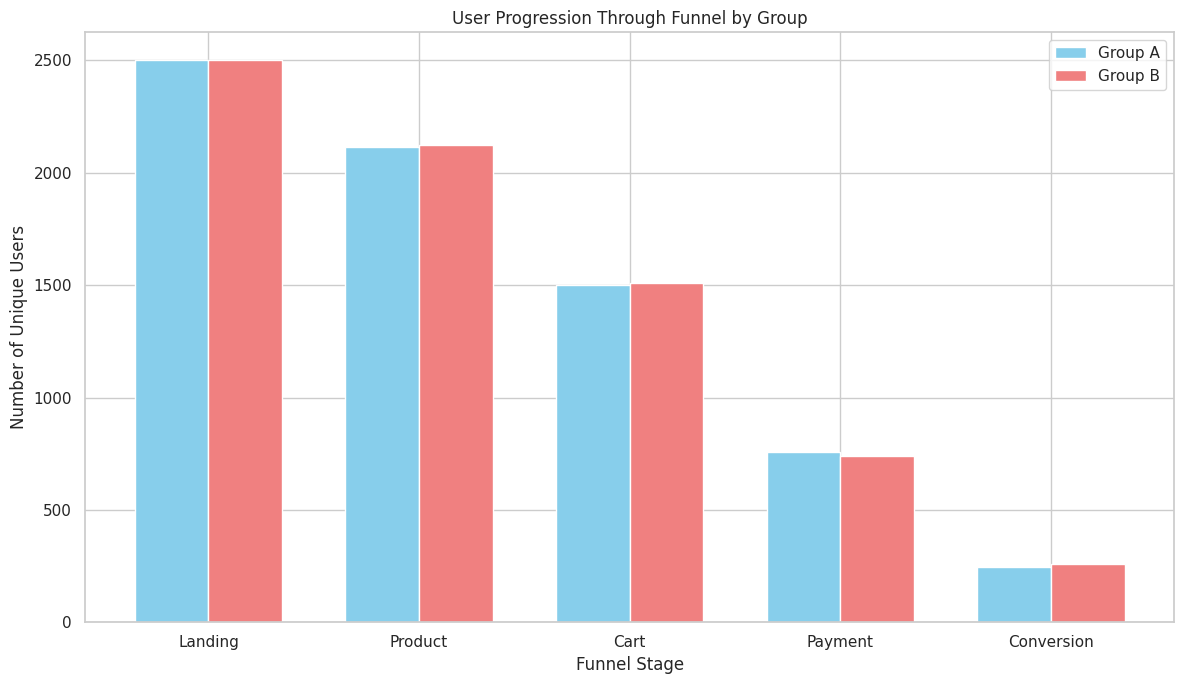

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for better aesthetics
sns.set_theme(style="whitegrid")

# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(12, 7))
bar_width = 0.35
stages = funnel_analysis['funnel_stage'].cat.categories # Get categories in correct order

# Plot bars for Group A
group_a_data = funnel_analysis[funnel_analysis['group'] == 'A']
ax.bar([i - bar_width/2 for i in range(len(stages))], group_a_data['user_id'], bar_width, label='Group A', color='skyblue')

# Plot bars for Group B
group_b_data = funnel_analysis[funnel_analysis['group'] == 'B']
ax.bar([i + bar_width/2 for i in range(len(stages))], group_b_data['user_id'], bar_width, label='Group B', color='lightcoral')

# Set labels, title, and ticks
ax.set_xlabel('Funnel Stage')
ax.set_ylabel('Number of Unique Users')
ax.set_title('User Progression Through Funnel by Group')
ax.set_xticks(range(len(stages)))
ax.set_xticklabels(stages)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Step 6: Interpretation and Conclusion

Let's summarize the findings from the A/B test and the funnel analysis.

**A/B Testing Results:**

The A/B test comparing the overall conversion rates between Group A and Group B showed a p-value of {{p_val:.4f}}, which is greater than the significance level of 0.05. Therefore, based on this test, there is no statistically significant difference in the overall conversion rates between the two groups.

**Funnel Analysis Results:**

The funnel analysis provides a more detailed view of user behavior at each stage. By comparing the number of users at each stage and the conversion rates between stages for Group A and Group B, we can identify potential bottlenecks or differences in user flow within the funnel, even if the overall conversion rate is similar.

*Interpret the funnel visualization and the funnel analysis table here, comparing the two groups at each stage.*

**Conclusion:**

Based on the A/B test, there is no statistically significant difference in overall conversion between the groups. However, the funnel analysis provides insights into user behavior at each stage, which can inform further investigation or optimization efforts. While the overall conversion might be similar, there could be differences in how users drop off or proceed through specific stages.